# GANs-Animation Character Generator
This notebook provides a examplar application of GANs. We trained the neural network with animation figures.

Reference:
1. https://www.kaggle.com/balraj98/context-encoder-gan-for-image-inpainting-pytorch/output

## Import the necessary packages

In [1]:
import numpy as np
import pandas as pd
import os, math, sys
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from PIL import Image
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

random.seed(42)
import warnings
warnings.filterwarnings("ignore")

## Set Parameters

In [8]:
# load pretrained models
load_pretrained_models = False
# number of epochs of training
n_epochs = 75
# size of the batches
batch_size = 16
# name of the dataset
dataset_name = "./data/tiny-imagenet-200"
# adam: learning rate
lr = 0.00008
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of first order momentum of gradient
b2 = 0.999
# number of cpu threads to use during batch generation
n_cpu = 4
# dimensionality of the latent space
latent_dim = 100
# size of each image dimension
img_size = 64
# size of random mask
mask_size = 32
# number of image channels
channels = 3
# interval between image sampling
sample_interval = 500

cuda = True if torch.cuda.is_available() else False
os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

# Calculate output dims of image discriminator (PatchGAN)
patch_h, patch_w = int(mask_size / 2 ** 3), int(mask_size / 2 ** 3)
patch = (1, patch_h, patch_w)

## Data Handler

In [9]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, img_size=64, mask_size=32, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.img_size = img_size
        self.mask_size = mask_size
        self.mode = mode
        self.files = sorted(glob.glob("%s/*.JPEG" % root))
        self.files = self.files[:-20] if mode == "train" else self.files[-20:]
        
    def apply_random_mask(self, img):
        """Randomly masks image"""
        y1, x1 = np.random.randint(0, self.img_size - self.mask_size, 2)
        y2, x2 = y1 + self.mask_size, x1 + self.mask_size
        masked_part = img[:, y1:y2, x1:x2]
        masked_img = img.clone()
        masked_img[:, y1:y2, x1:x2] = 1

        return masked_img, masked_part

    def apply_center_mask(self, img):
        """Mask center part of image"""
        # Get upper-left pixel coordinate
        i = (self.img_size - self.mask_size) // 2
        masked_img = img.clone()
        masked_img[:, i : i + self.mask_size, i : i + self.mask_size] = 1

        return masked_img, i

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img = img.convert("RGB")
        img = self.transform(img)
        if self.mode == "train":
            # For training data perform random mask
            masked_img, aux = self.apply_random_mask(img)
        else:
            # For test data mask the center of the image
            masked_img, aux = self.apply_center_mask(img)
        return img, masked_img, aux

    def __len__(self):
        return len(self.files)

#### Load images into dataLoader

In [10]:
transforms_ = [
    transforms.Resize((img_size, img_size), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5)),
]
dataloader = DataLoader(
    ImageDataset(dataset_name, transforms_=transforms_),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)
test_dataloader = DataLoader(
    ImageDataset(dataset_name, transforms_=transforms_, mode="val"),
    batch_size=12,
    shuffle=True,
    num_workers=1,
)

## Define NN
The structure used here is presented below

![struct](img/inpaint.png)

In [11]:
class Generator(nn.Module):
    def __init__(self, channels=3):
        super(Generator, self).__init__()

        def downsample(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        def upsample(in_feat, out_feat, normalize=True):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.ReLU())
            return layers

        self.model = nn.Sequential(
            *downsample(channels, 32, normalize=False),
            *downsample(32, 32),
            *downsample(32, 64),
            *downsample(64, 128),
            *downsample(128, 256),
            *downsample(256, 512),
            nn.Conv2d(512, 4000, 1),
            *upsample(4000, 512),
            *upsample(512, 256),
            *upsample(256, 128),
            *upsample(128, 64),
            *upsample(64, 32),
            nn.Conv2d(32, channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, stride, normalize):
            """Returns layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 3, stride, 1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = channels
        for out_filters, stride, normalize in [(64, 2, False), (128, 2, True), (256, 2, True), (512, 1, True)]:
            layers.extend(discriminator_block(in_filters, out_filters, stride, normalize))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, 3, 1, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

## Prepare for Training

In [12]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

def save_sample(batches_done):
    samples, masked_samples, i = next(iter(test_dataloader))
    samples = Variable(samples.type(Tensor))
    masked_samples = Variable(masked_samples.type(Tensor))
    i = i[0].item()  # Upper-left coordinate of mask
    # Generate inpainted image
    gen_mask = generator(masked_samples)
    filled_samples = masked_samples.clone()
    filled_samples[:, :, i : i + mask_size, i : i + mask_size] = gen_mask
    # Save sample
    sample = torch.cat((masked_samples.data, filled_samples.data, samples.data), -2)
    save_image(sample, "images/%d.png" % batches_done, nrow=6, normalize=True)

    
# Loss function
adversarial_loss = torch.nn.MSELoss()
pixelwise_loss = torch.nn.L1Loss()

# Initialize generator and discriminator
generator = Generator(channels=channels)
discriminator = Discriminator(channels=channels)

# Load pretrained models
if load_pretrained_models:
    generator.load_state_dict(torch.load("./saved_models/generator.pth"))
    discriminator.load_state_dict(torch.load("./saved_models/discriminator.pth"))
    print("Using pre-trained Context-Encoder GAN model!")

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    pixelwise_loss.cuda()

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

## Train the Net

In [13]:
gen_adv_losses, gen_pixel_losses, disc_losses, counter = [], [], [], []

for epoch in range(n_epochs):
    
    ### Training ###
    gen_adv_loss, gen_pixel_loss, disc_loss = 0, 0, 0
    tqdm_bar = tqdm(dataloader, desc=f'Training Epoch {epoch} ', total=int(len(dataloader)), file=sys.stdout)
    for i, (imgs, masked_imgs, masked_parts) in enumerate(tqdm_bar):
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], *patch).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], *patch).fill_(0.0), requires_grad=False)

        # Configure input
        imgs = Variable(imgs.type(Tensor))
        masked_imgs = Variable(masked_imgs.type(Tensor))
        masked_parts = Variable(masked_parts.type(Tensor))

        ## Train Generator ##
        optimizer_G.zero_grad()

        # Generate a batch of images
        gen_parts = generator(masked_imgs)

        # Adversarial and pixelwise loss
        g_adv = adversarial_loss(discriminator(gen_parts), valid)
        g_pixel = pixelwise_loss(gen_parts, masked_parts)
        # Total loss
        g_loss = 0.001 * g_adv + 0.999 * g_pixel

        g_loss.backward()
        optimizer_G.step()

        ## Train Discriminator ##
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(masked_parts), valid)
        fake_loss = adversarial_loss(discriminator(gen_parts.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()
        
        gen_adv_loss, gen_pixel_loss, disc_loss
        gen_adv_losses, gen_pixel_losses, disc_losses, counter
        
        gen_adv_loss += g_adv.item()
        gen_pixel_loss += g_pixel.item()
        gen_adv_losses.append(g_adv.item())
        gen_pixel_losses.append(g_pixel.item())
        disc_loss += d_loss.item()
        disc_losses.append(d_loss.item())
        counter.append(i*batch_size + imgs.size(0) + epoch*len(dataloader.dataset))
        tqdm_bar.set_postfix(gen_adv_loss=gen_adv_loss/(i+1), gen_pixel_loss=gen_pixel_loss/(i+1), disc_loss=disc_loss/(i+1))
        
        # Generate sample at sample interval
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            
            save_sample(batches_done)
    sys.stderr.flush()
    torch.save(generator.state_dict(), "saved_models/generator.pth")
    torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")

## Check Result

In [14]:
import torchvision.utils as vutils
# Grab a batch of real images from the dataloader
imgs, masked_imgs, _ = next(iter(test_dataloader))
inpaints = generator(masked_imgs.to("cuda")).detach().cpu()

In [15]:
def add_inpaint(mask, inpaint):
    ret = torch.zeros(mask.shape)
    for i in range(len(mask)):
        x = torch.clone(inpaint[i])
        y = torch.clone(mask[i])
        x_range = x.shape[1]
        y_range = x.shape[2]
        left_x = (y.shape[1]-x_range) // 2
        left_y = (y.shape[2]-y_range) // 2
        y[..., left_x:left_x+x_range,left_y:left_y+y_range] = x
        ret[i] = y
    return ret

In [16]:
masked = vutils.make_grid(masked_imgs, nrow=4, normalize=True)
org = vutils.make_grid(imgs, nrow=4, normalize=True)
painted = vutils.make_grid(add_inpaint(masked_imgs, inpaints), nrow=4, normalize=True)

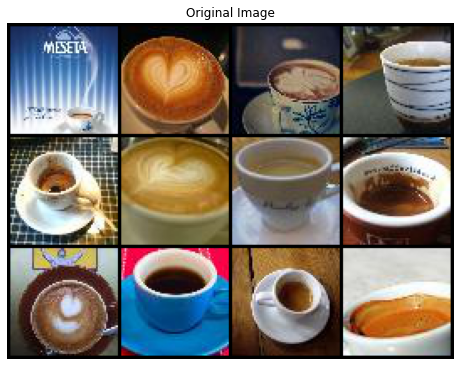

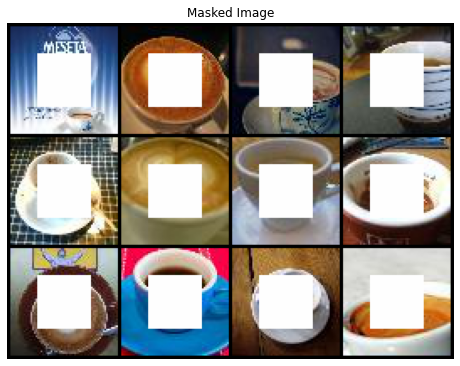

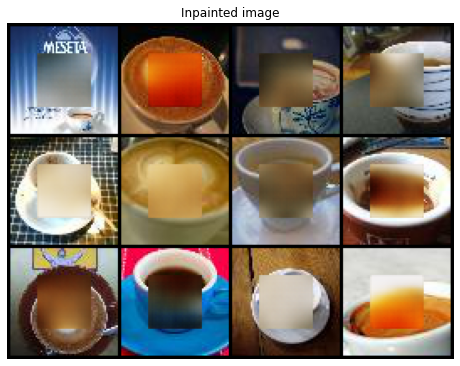

In [17]:
# Plot the fake images from the last epoch
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Original Image")
plt.imshow(np.transpose(org,(1,2,0)))

plt.show()
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Masked Image")
plt.imshow(np.transpose(masked,(1,2,0)))
plt.show()
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Inpainted image")
plt.imshow(np.transpose(painted,(1,2,0)))
plt.show()